[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryan9dai/XAI590_Ryan/blob/main/XAI_Assignment5.ipynb)


# Hypothesis

H0: A CNN model trained for skin cancer detection of moles looks at other areas of the image rather than the mole itself.

H1: A CNN model trained for skin cancer detection of moles looks at the mole itself rather than other areas of the image.

In [6]:
#!pip install torch torchvision pandas matplotlib scikit-learn tqdm numpy kagglehub scipy

## Running Notes
Note that running this notebook involves training a CNN based on ResNet, and requires some decent hardware. 
Please install the appropriate torch version. I'm using cuda 11.8 for my RTX 4070 Super, which runs the code in less than 5 mins including training.
The notebook allows saving and loading the trained model, and has a directory path for the saved model that you need to specify (any local directory will do). Lines 133, 137, 385.
The code will download the dataset to a directory managed by Kagglehub and will also cache transformed images so that it can be reran without processing the dataset again.

Pre-caching images...


Caching images: 100%|████████████████████████████████████████████████████████████| 4000/4000 [00:03<00:00, 1051.00it/s]


Pre-caching images...


Caching images: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1019.86it/s]


Pre-caching images...


Caching images: 100%|████████████████████████████████████████████████████████████| 5015/5015 [00:04<00:00, 1077.48it/s]
                                                                                                                       

Epoch 1: Training Loss: 0.3810, Validation Loss: 0.0020, Validation Accuracy: 1.0000


Epoch 2: Training Loss: 0.1818, Validation Loss: 0.0159, Validation Accuracy: 0.9980


Epoch 3: Training Loss: 0.0897, Validation Loss: 0.0103, Validation Accuracy: 0.9960


Epoch 4: Training Loss: 0.0470, Validation Loss: 0.0018, Validation Accuracy: 1.0000


Epoch 5: Training Loss: 0.0503, Validation Loss: 0.0322, Validation Accuracy: 0.9860


Epoch 6: Training Loss: 0.0447, Validation Loss: 0.0103, Validation Accuracy: 0.9970


Epoch 7: Training Loss: 0.0253, Validation Loss: 0.0024, Validation Accuracy: 0.9990


Epoch 8: Training Loss: 0.0246, Validation Loss: 0.0014, Validation Accuracy: 1.0000


Epoch 9: Training Loss: 0.0083, Validation Loss: 0.0013, Validation Accuracy: 0.9990


Epoch 10: Training Loss: 0.0203, Validation Loss: 0.0060, Validation Accuracy: 0.9970


Final Test Loss: 2.1186, Final Test Accuracy: 0.6014


C:\Users\ryan9\AppData\Local\Temp\ipykernel_15996\1738782620.py:256: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mal_tcav_scores, mal_bg_scores], labels=["Malignant Mole", "Background Skin (from malignant images)"])


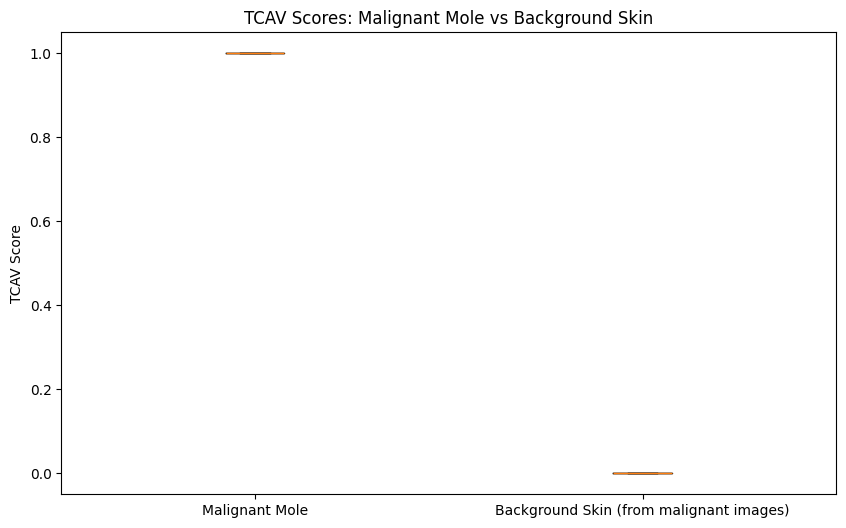

C:\Users\ryan9\AppData\Local\Temp\ipykernel_15996\1738782620.py:263: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ben_tcav_scores, ben_bg_scores], labels=["Benign Mole", "Background Skin (from benign images)"])


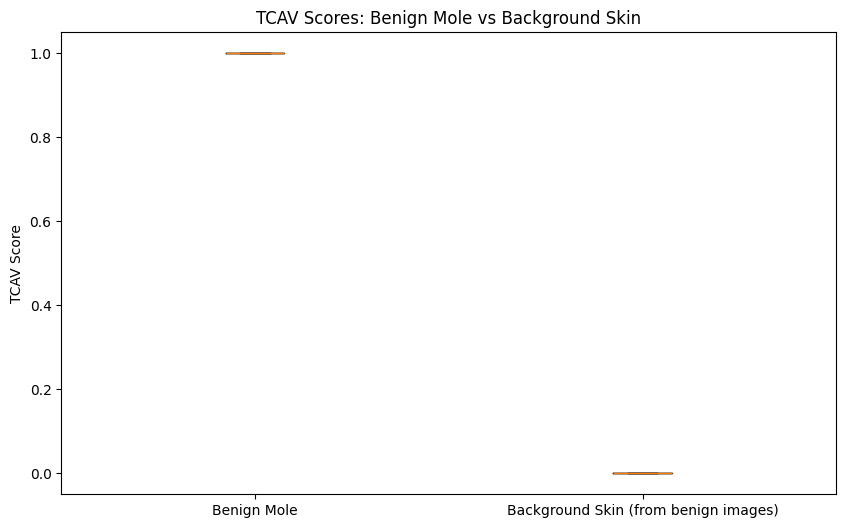

C:\Users\ryan9\Documents\Projects\XAI\Xvenv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\ryan9\Documents\Projects\XAI\Xvenv\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Final TCAV Score for Malignant Mole: 1.0000
Final TCAV Score for Background (malignant): 0.0000
Final TCAV Score for Benign Mole: 1.0000
Final TCAV Score for Background (benign): 0.0000
Malignant Mole vs Background: t-statistic = inf, p-value = 0.0000
Benign Mole vs Background: t-statistic = inf, p-value = 0.0000
Reject H0 for malignant: The model focuses on the malignant mole rather than background.
Reject H0 for benign: The model focuses on the benign mole rather than background.
Malignant Samples:


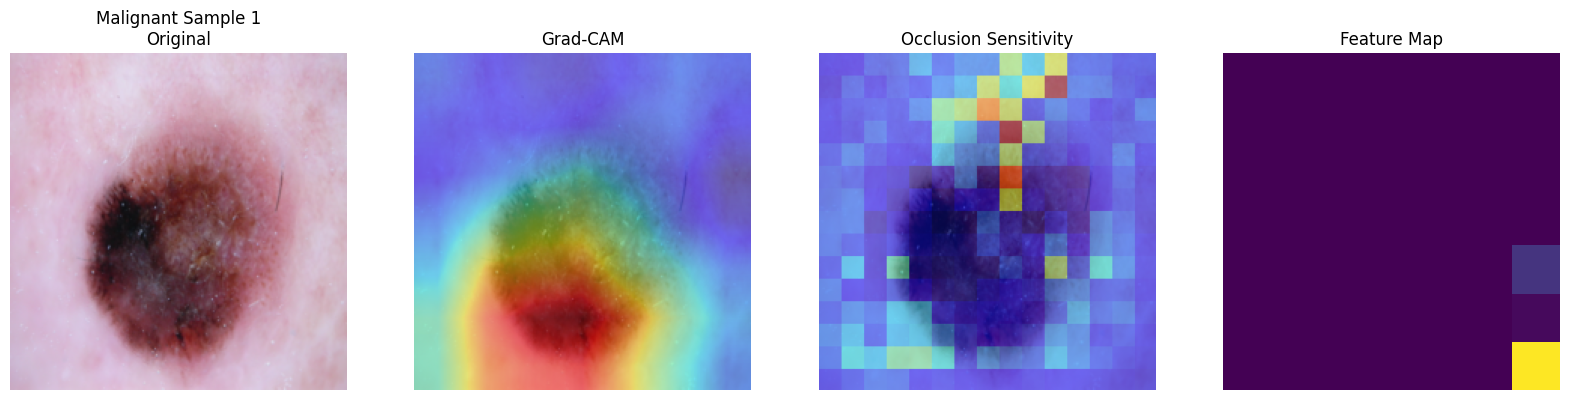

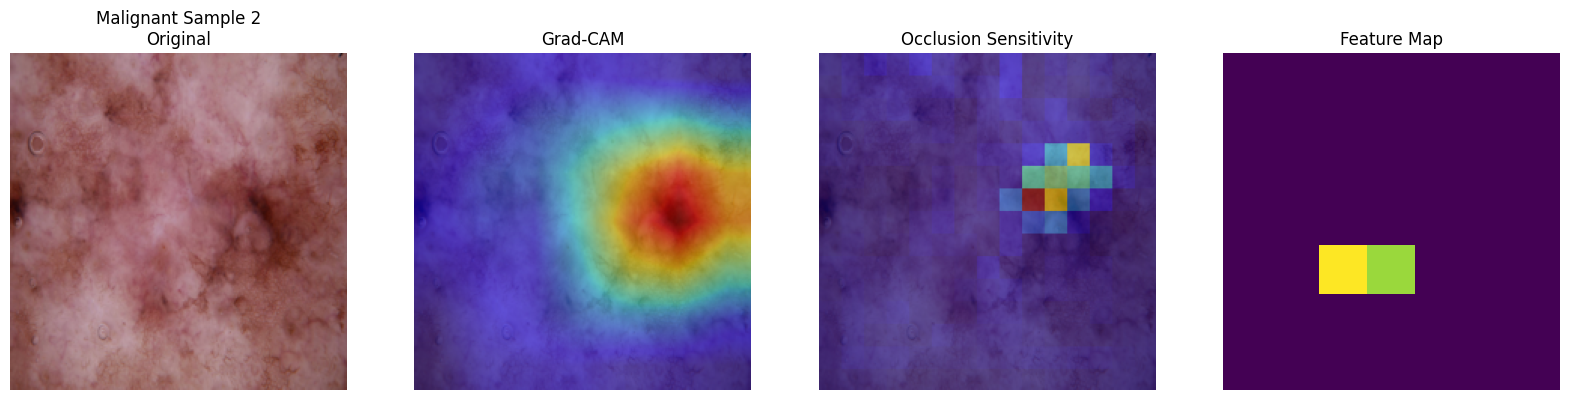

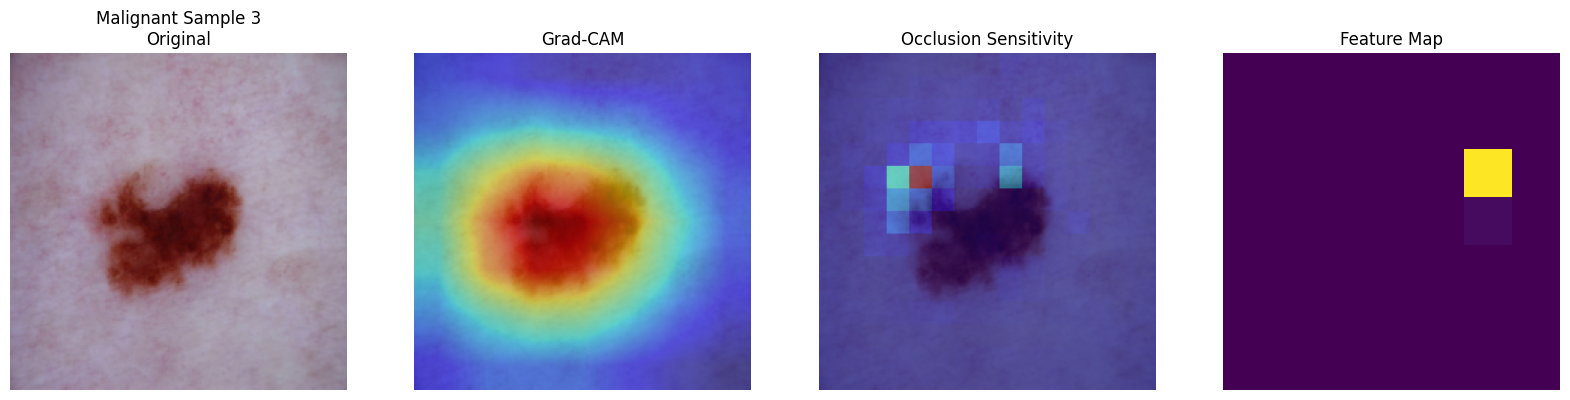

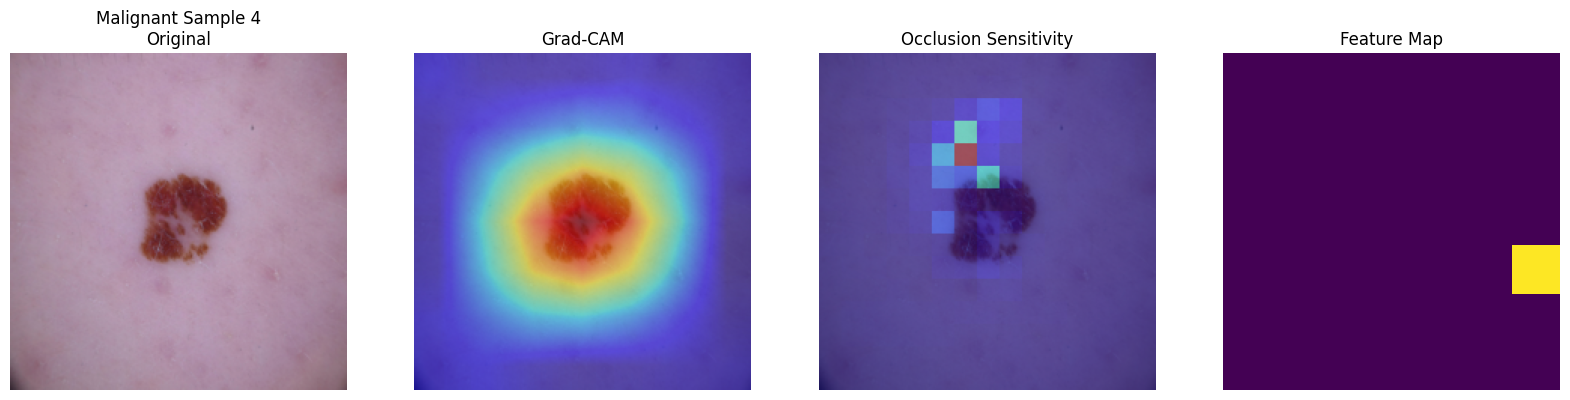

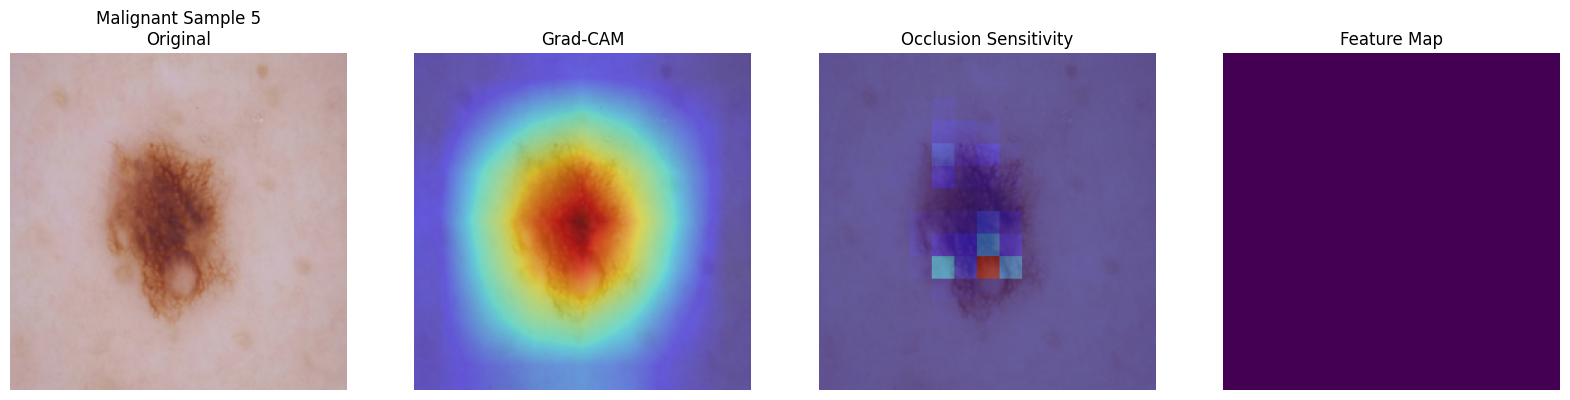

Benign Samples:


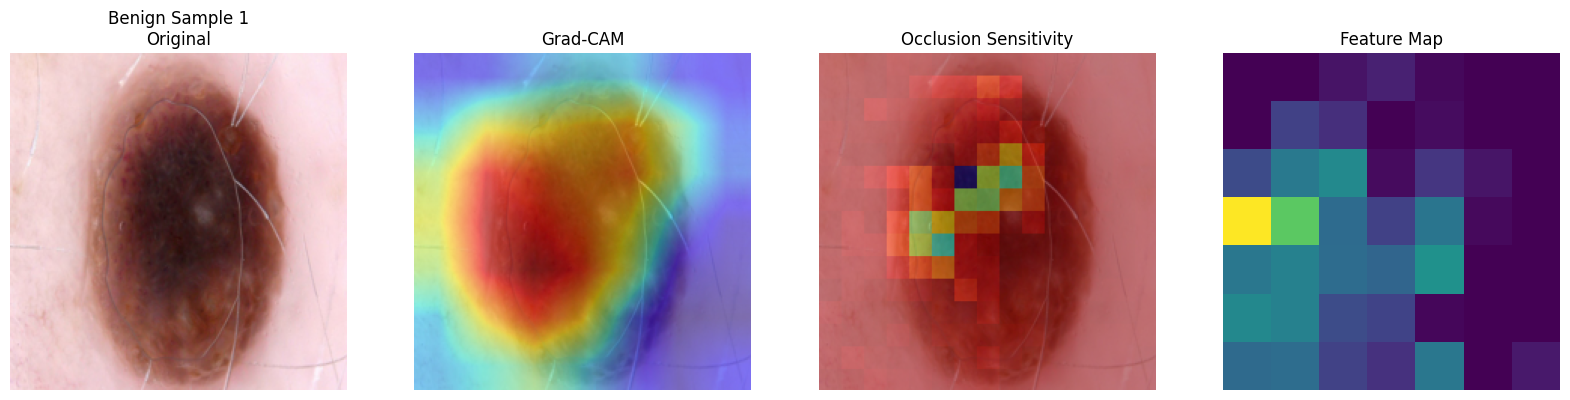

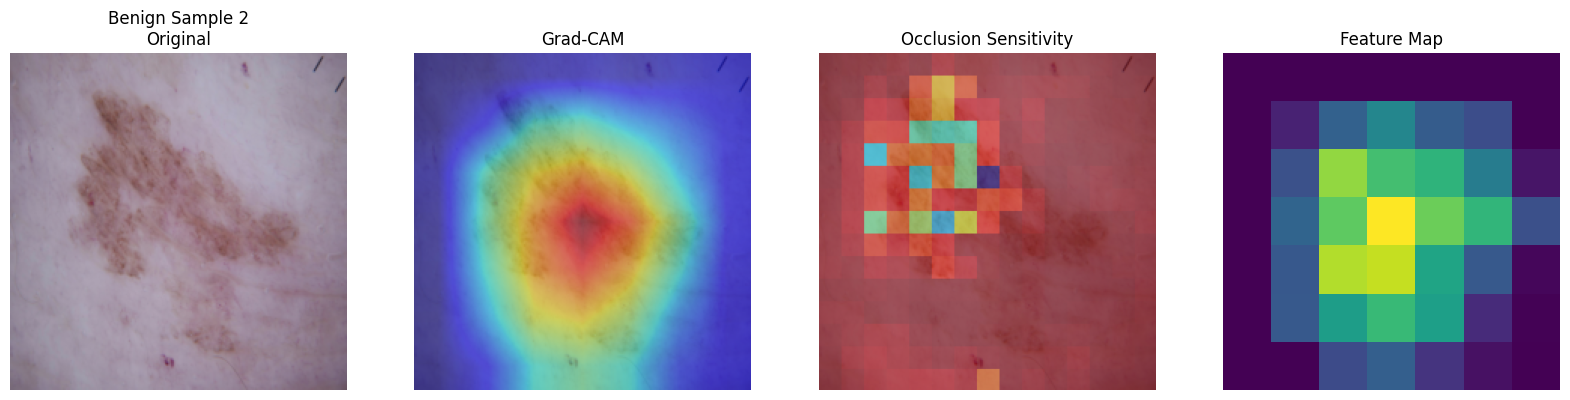

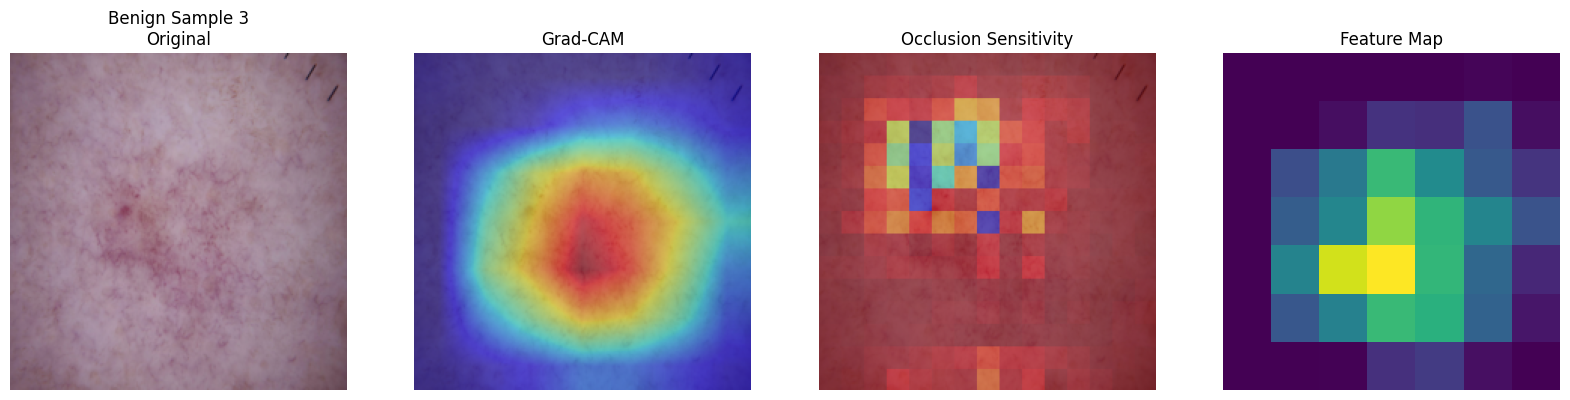

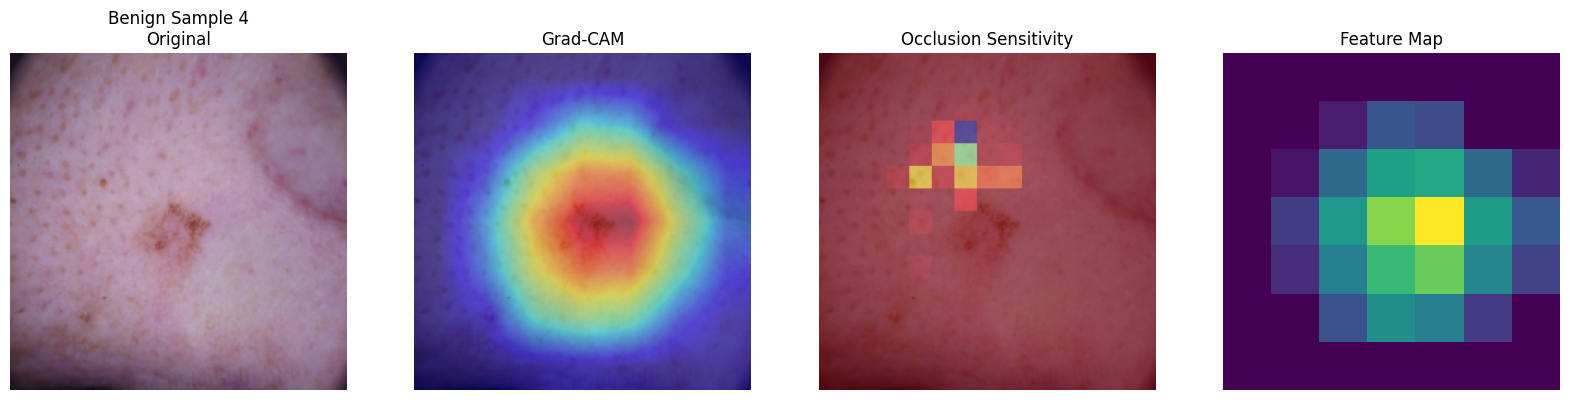

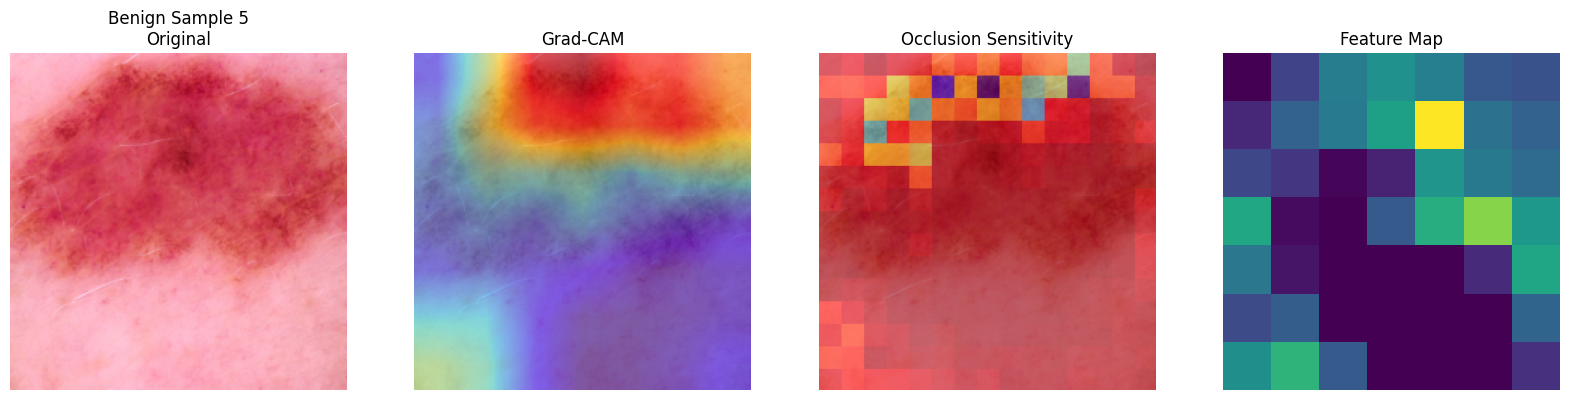

Trained model saved successfully at C:\Users\ryan9\Documents\Projects\XAI\XAI_Local\custom_resnet_20250212_175627.pth


In [6]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm
import numpy as np
import datetime
import kagglehub
from scipy.stats import ttest_ind
import torch.nn.functional as F

# ---------------------- Utility Cropping Functions ----------------------
def crop_center(image, crop_size=112):
    _, H, W = image.shape
    start_h = (H - crop_size) // 2
    start_w = (W - crop_size) // 2
    return image[:, start_h:start_h+crop_size, start_w:start_w+crop_size]

def crop_top_left(image, crop_size=112):
    return image[:, :crop_size, :crop_size]

def crop_center_resize(image, crop_size=112, target_size=224):
    cropped = crop_center(image, crop_size)
    cropped = F.interpolate(cropped.unsqueeze(0), size=(target_size, target_size), mode='bilinear', align_corners=False).squeeze(0)
    return cropped

def crop_top_left_resize(image, crop_size=112, target_size=224):
    cropped = crop_top_left(image, crop_size)
    cropped = F.interpolate(cropped.unsqueeze(0), size=(target_size, target_size), mode='bilinear', align_corners=False).squeeze(0)
    return cropped

# ---------------------- Data Setup ----------------------
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
df = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))
# Labeling: 1 = malignant mole, 0 = benign lesion
df["label"] = df["dx"].apply(lambda x: 1 if x == "mel" else 0)
df["image_path"] = df["image_id"].apply(
    lambda x: os.path.join(path, "HAM10000_images_part_1", f"{x}.jpg")
    if os.path.exists(os.path.join(path, "HAM10000_images_part_1", f"{x}.jpg"))
    else os.path.join(path, "HAM10000_images_part_2", f"{x}.jpg")
)
train_df = df.iloc[:5000]
test_df  = df.iloc[5000:]
train_df, val_df = train_df.iloc[:4000], train_df.iloc[4000:]

cache_dir = "processed_ham10000"
os.makedirs(cache_dir, exist_ok=True)

class HAM10000Dataset(Dataset):
    def __init__(self, df, transform=None, cache=True, cache_dir=cache_dir, precache=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.cache = cache
        self.cache_dir = cache_dir
        if self.cache and precache:
            print("Pre-caching images...")
            for i in tqdm(range(len(self.df)), desc="Caching images"):
                _ = self.__getitem__(i)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_id = row["image_id"]
        label = torch.tensor(row["label"], dtype=torch.long)
        cache_path = os.path.join(self.cache_dir, f"{image_id}.pt")
        if self.cache and os.path.exists(cache_path):
            image = torch.load(cache_path, map_location="cpu")
        else:
            img_path = row["image_path"]
            image = read_image(img_path).float() / 255.0
            if self.transform:
                image = self.transform(image)
            if self.cache:
                torch.save(image, cache_path)
        return image, label

transform = transforms.Compose([transforms.Resize((224, 224))])
train_dataset = HAM10000Dataset(train_df, transform, precache=True)
val_dataset   = HAM10000Dataset(val_df, transform, precache=True)
test_dataset  = HAM10000Dataset(test_df, transform, precache=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ---------------------- Model Setup ----------------------
base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for name, param in base_model.named_parameters():
    param.requires_grad = ("layer4" in name)

class CustomResNet(nn.Module):
    def __init__(self, base_model):
        super(CustomResNet, self).__init__()
        self.base = base_model
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(base_model.fc.in_features, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)
        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CustomResNet(base_model).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# ---------------------- Bypass Training Option ----------------------
# Set LOAD_PRETRAINED = True to load the latest locally saved model and bypass training.
LOAD_PRETRAINED = False
# LOAD_PRETRAINED = True

if LOAD_PRETRAINED:
    save_dir = r"C:\Users\ryan9\Documents\Projects\XAI\XAI_Local" # REPLACE THIS WITH YOUR PREFERRED FOLDER
    saved_models = glob.glob(os.path.join(save_dir, "custom_resnet_*.pth"))
    if saved_models:
        latest_model = max(saved_models, key=os.path.getctime)
        model.load_state_dict(torch.load(latest_model, map_location=device))
        print(f"Loaded pretrained model from {latest_model}")
    else:
        print("No pretrained model found. Proceeding with training.")
else:
    def evaluate(model, loader, criterion):
        model.eval()
        total_loss, correct, count = 0, 0, 0
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).long()
            correct += (preds == labels.long()).sum().item()
            count += imgs.size(0)
        return total_loss / count, correct / count

    def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
                imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * imgs.size(0)
            train_loss = epoch_loss / len(train_loader.dataset)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            print(f"Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")

# ---------------------- Activation Extraction ----------------------
class ActivationExtractor(nn.Module):
    def __init__(self, model, layer_name):
        super().__init__()
        self.model = model
        self.layer_name = layer_name
        self.activations = []
    def hook_fn(self, module, input, output):
        self.activations.append(output.detach())
    def get_activations(self, x):
        self.activations = []
        handle = dict([*self.model.named_modules()])[self.layer_name].register_forward_hook(self.hook_fn)
        _ = self.model(x)
        handle.remove()
        return self.activations[0]

extractor = ActivationExtractor(model, "base.layer4")
def extract_acts(dataset, indices, crop_fn=None):
    acts = []
    for idx in indices:
        img, _ = dataset[idx]
        if crop_fn is not None:
            img = crop_fn(img)
        img = img.unsqueeze(0).to(device)
        act = extractor.get_activations(img)
        acts.append(act.view(act.size(1), -1).mean(dim=1).cpu().numpy())
    return np.array(acts)

# ---------------------- TCAV Analysis Based on Hypothesis ----------------------
# Hypothesis:
# H0: The CNN relies on background skin (non-mole) regions.
# H1: The CNN focuses on the mole itself.
# We define three concept sets:
#   1. Malignant Mole Concept (center-cropped from malignant images)
#   2. Benign Mole Concept (center-cropped from benign images)
#   3. Background Skin Concept (top-left cropped from images)

N = 10
sample_size = 30

# Get indices for each concept
malignant_indices = random.sample(list(train_df[train_df["label"] == 1].index), min(sample_size, len(train_df[train_df["label"] == 1])))
benign_indices = random.sample(list(train_df[train_df["label"] == 0].index), min(sample_size, len(train_df[train_df["label"] == 0])))
background_indices = random.sample(list(train_df.index), min(sample_size, len(train_df)))

mal_tcav_scores = []
mal_bg_scores = []
ben_tcav_scores = []
ben_bg_scores = []

for i in range(N):
    # Malignant Mole vs Background Skin (using cropped regions)
    mal_acts = extract_acts(train_dataset, malignant_indices, crop_fn=crop_center_resize)
    bg_acts_for_mal = extract_acts(train_dataset, background_indices, crop_fn=crop_top_left_resize)
    X = np.vstack([mal_acts, bg_acts_for_mal])
    y = [1]*len(mal_acts) + [0]*len(bg_acts_for_mal)
    clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
    clf.fit(X, y)
    mal_score = np.mean(clf.decision_function(mal_acts) > 0)
    bg_score_mal = np.mean(clf.decision_function(bg_acts_for_mal) > 0)
    mal_tcav_scores.append(mal_score)
    mal_bg_scores.append(bg_score_mal)
    
    # Benign Mole vs Background Skin
    ben_acts = extract_acts(train_dataset, benign_indices, crop_fn=crop_center_resize)
    bg_acts_for_ben = extract_acts(train_dataset, background_indices, crop_fn=crop_top_left_resize)
    X = np.vstack([ben_acts, bg_acts_for_ben])
    y = [1]*len(ben_acts) + [0]*len(bg_acts_for_ben)
    clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
    clf.fit(X, y)
    ben_score = np.mean(clf.decision_function(ben_acts) > 0)
    bg_score_ben = np.mean(clf.decision_function(bg_acts_for_ben) > 0)
    ben_tcav_scores.append(ben_score)
    ben_bg_scores.append(bg_score_ben)

# Boxplot for Malignant Mole vs Background Skin
plt.figure(figsize=(10,6))
plt.boxplot([mal_tcav_scores, mal_bg_scores], labels=["Malignant Mole", "Background Skin (from malignant images)"])
plt.title("TCAV Scores: Malignant Mole vs Background Skin")
plt.ylabel("TCAV Score")
plt.show()

# Boxplot for Benign Mole vs Background Skin
plt.figure(figsize=(10,6))
plt.boxplot([ben_tcav_scores, ben_bg_scores], labels=["Benign Mole", "Background Skin (from benign images)"])
plt.title("TCAV Scores: Benign Mole vs Background Skin")
plt.ylabel("TCAV Score")
plt.show()

final_mal_tcav = np.mean(mal_tcav_scores)
final_mal_bg = np.mean(mal_bg_scores)
final_ben_tcav = np.mean(ben_tcav_scores)
final_ben_bg = np.mean(ben_bg_scores)
print(f"Final TCAV Score for Malignant Mole: {final_mal_tcav:.4f}")
print(f"Final TCAV Score for Background (malignant): {final_mal_bg:.4f}")
print(f"Final TCAV Score for Benign Mole: {final_ben_tcav:.4f}")
print(f"Final TCAV Score for Background (benign): {final_ben_bg:.4f}")

# One-tailed t-tests
t_stat_mal, p_value_mal = ttest_ind(mal_tcav_scores, mal_bg_scores, alternative="greater")
t_stat_ben, p_value_ben = ttest_ind(ben_tcav_scores, ben_bg_scores, alternative="greater")
print(f"Malignant Mole vs Background: t-statistic = {t_stat_mal:.4f}, p-value = {p_value_mal:.4f}")
print(f"Benign Mole vs Background: t-statistic = {t_stat_ben:.4f}, p-value = {p_value_ben:.4f}")
alpha = 0.05
if p_value_mal < alpha:
    print("Reject H0 for malignant: The model focuses on the malignant mole rather than background.")
else:
    print("Fail to reject H0 for malignant: No strong evidence that the model focuses on the malignant mole.")
if p_value_ben < alpha:
    print("Reject H0 for benign: The model focuses on the benign mole rather than background.")
else:
    print("Fail to reject H0 for benign: No strong evidence that the model focuses on the benign mole.")

# ---------------------- Grad-CAM Function ----------------------
def grad_cam(model, image, target_layer="base.layer4", target_class=1):
    model.eval()
    activations, gradients = {}, {}
    def forward_hook(module, input, output):
        activations["value"] = output
    def backward_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0]
    target_module = dict([*model.named_modules()])[target_layer]
    h1 = target_module.register_forward_hook(forward_hook)
    h2 = target_module.register_backward_hook(backward_hook)
    image_in = image.unsqueeze(0).to(device)
    output = model(image_in)
    score = output if target_class == 1 else -output
    model.zero_grad()
    score.backward()
    act = activations["value"].detach()
    grad = gradients["value"].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = torch.relu((weights * act).sum(dim=1, keepdim=True))
    cam = F.interpolate(cam, size=(224, 224), mode="bilinear", align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    h1.remove(); h2.remove()
    return cam

# ---------------------- Occlusion Sensitivity Function ----------------------
def occlusion_sensitivity(model, image, target_class=1, occlusion_size=30, occlusion_stride=15, occlusion_value=0):
    model.eval()
    _, C, H, W = image.unsqueeze(0).shape
    baseline_prob = torch.sigmoid(model(image.unsqueeze(0).to(device))).item()
    sensitivity_map = np.zeros((H, W))
    for y in range(0, H, occlusion_stride):
        for x in range(0, W, occlusion_stride):
            occluded = image.clone()
            y1, y2 = y, min(y + occlusion_size, H)
            x1, x2 = x, min(x + occlusion_size, W)
            occluded[:, y1:y2, x1:x2] = occlusion_value
            prob = torch.sigmoid(model(occluded.unsqueeze(0).to(device))).item()
            sensitivity_map[y:y2, x:x2] = baseline_prob - prob
    sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min() + 1e-8)
    return sensitivity_map, baseline_prob

# ---------------------- Sample Visualizations ----------------------
# For each sample, show: Original, Grad-CAM, Occlusion Sensitivity, Feature Map.
def display_sample(image, target_class, sample_title):
    # Original image
    orig = image.permute(1, 2, 0).cpu().numpy()
    # Grad-CAM overlay
    cam = grad_cam(model, image, "base.layer4", target_class)
    # Occlusion Sensitivity overlay
    sens_map, _ = occlusion_sensitivity(model, image, target_class)
    # Feature Map (first feature map as example)
    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())
    handle = dict([*model.named_modules()])["base.layer4"].register_forward_hook(hook_fn)
    _ = model(image.unsqueeze(0).to(device))
    handle.remove()
    feat_map = activations[0].squeeze(0)[0].numpy()

    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    axs[0].imshow(orig)
    axs[0].set_title(f"{sample_title}\nOriginal")
    axs[0].axis("off")
    axs[1].imshow(orig)
    axs[1].imshow(cam, cmap="jet", alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis("off")
    axs[2].imshow(orig)
    axs[2].imshow(sens_map, cmap="jet", alpha=0.5)
    axs[2].set_title("Occlusion Sensitivity")
    axs[2].axis("off")
    axs[3].imshow(feat_map, cmap="viridis")
    axs[3].set_title("Feature Map")
    axs[3].axis("off")
    plt.show()

# Display 5 Malignant Samples and 5 Benign Samples
print("Malignant Samples:")
malignant_sample_indices = random.sample(list(train_df[train_df["label"] == 1].index), 5)
for i, idx in enumerate(malignant_sample_indices):
    img, _ = train_dataset[idx]
    display_sample(img, target_class=1, sample_title=f"Malignant Sample {i+1}")

print("Benign Samples:")
benign_sample_indices = random.sample(list(train_df[train_df["label"] == 0].index), 5)
for i, idx in enumerate(benign_sample_indices):
    img, _ = train_dataset[idx]
    display_sample(img, target_class=0, sample_title=f"Benign Sample {i+1}")

# ---------------------- Save Model (Only if Training was Performed) ----------------------
if not LOAD_PRETRAINED:
    save_dir = r"C:\Users\ryan9\Documents\Projects\XAI\XAI_Local"  # REPLACE THIS WITH YOUR PREFERRED FOLDER
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(save_dir, f"custom_resnet_{timestamp}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Trained model saved successfully at {save_path}")


### Overview
The model is trained to detect malignant and benign moles, but we want to find out if it's really using the mole itself or the background to make its judgment.

### Hypothesis
H0: The CNN model for skin cancer detection relies on background skin rather than the mole itself.  
H1: The model primarily attends to the mole when making its decision.

### Approach
I based a CNN model on ResNet-50 to categorize cancerous moles. I adapted ResNet to the dataset by unfreezing the 4th and last layer and freezing the rest, then replacing the final connected layer with a simple custom one. This resulted in a test accuracy of around 60% training for 10 epochs, (it can get to 70% with 20 epochs). The accuracy of the model was not important provided it was above 50%, as we're primarily analyzing what it is looking at to make its decisions.

To see what the model is really paying attention to, we use:

- TCAV (Testing with Concept Activation Vectors): This helps us quantify how much the model relies on different concepts, like malignant moles, benign moles, and background skin. We center-crop the images for the concepts so that the mole concepts are focusing on the mole itself, and randomly crop the corner for background skin concepts.

- Feature Maps: By extracting activations from the 4th layer of ResNet, we get a glimpse into how the model encodes visual features.

- Grad-CAM & Occlusion Sensitivity: These visualize the regions that the model is looking at for its predictions, and will show if the model focuses on the surrounding skin rather than the mole itself.

### Experiment and Results

#### TCAV Scores
I tested the model’s reliance on three distinct concepts:

- Malignant Mole (center-cropped)

- Benign Mole (center-cropped)

- Background Skin (random cropped patches from non-mole areas)

The results:
- Malignant Mole TCAV: 1.0000
- Background (Malignant): 0.0000
- Benign Mole TCAV: 1.0000
- Background (Benign): 0.0000

This indicates that the model is indeed focusing on the mole itself rather than the background.

#### Statistical Significance
I used a one-tailed t-test to test the significance of the results:
Malignant Mole vs. Background: t-stat = inf, p = 0.0000 → Reject H0.
Benign Mole vs. Background: t-stat = inf, p = 0.0000 → Reject H0.

Since p-values are well below the 0.05 threshold, we can confidently say that the model focuses on the lesion rather than the background.

#### Grad-CAM & Occlusion Sensitivity
Grad-CAM heatmaps align strongly with the mole pattern itself, showing that the mole is contributing to predictions.
Occlusion Sensitivity confirms this — covering the mole drastically reduces classification confidence.
Feature Maps typically align with the mole, although for cancerous moles it is not so obvious.

### Conclusion
The model is working as intended. It’s not relying on the background skin, but instead making its decision based on the mole itself. We can safely reject the null hypothesis and accept H1.

# Sources: 

Dataset: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

AI Models used: ChatGPT 4o (for general questions, ideas and technical help) and o3 (for coding). Used on Feb 12 2025

TCAV notebook read to understand at a high level how to implement TCAV:
https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb

# USE OF AI

I heavily relied on o3 to do the coding heavylifting, but I gave it a lot of guidance over many iterations. I decided on the model architecture. I used 4o to discuss the appropriate TCAV concepts given my hypothesis, as well as many decisions such as the appropriate statistical test, which techniques and visualizations to use, and how to present the results. The entire code is written by o3 and the report is structured by 4o and rewritten by me. 